In [ ]:
# Description: This program uses an artificial Recurrent Neural Networks(RNN) called Long Short Term Memory(LSTM)
#              To predict the closing stock price of a corporation (Apple Inc.).

In [1]:
# Import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [52]:
# Get the stock quote
df = web.DataReader("AAPL", data_source = "yahoo", start = "2012-01-01", end = "2020-07-01")
# Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792
...,...,...,...,...,...,...
2020-06-25,365.000000,357.570007,360.700012,364.839996,34380600.0,364.839996
2020-06-26,365.320007,353.019989,364.410004,353.630005,51314200.0,353.630005
2020-06-29,362.170013,351.279999,353.250000,361.779999,32661500.0,361.779999


In [53]:
# Get the number of rows and columns in the data set
df.shape

(2138, 6)

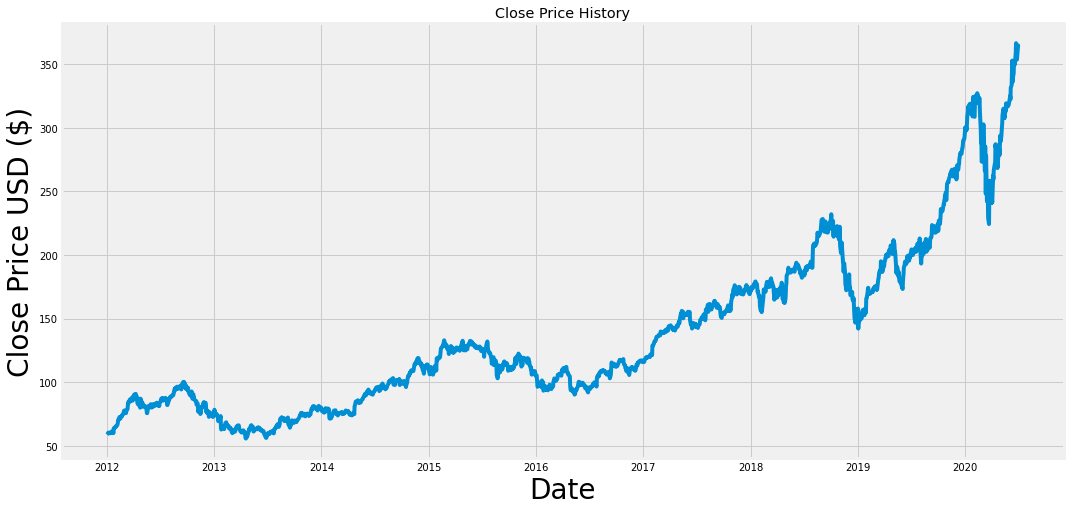

In [54]:
 # Visualize the closing price history
 plt.figure(figsize = (16, 8))
 plt.title("Close Price History")
 plt.plot(df["Close"])
 plt.xlabel("Date", fontsize = 28)
 plt.ylabel("Close Price USD ($)", fontsize = 28)
 plt.show()

In [55]:
# Create a new dataframe with only the "Close column"
data = df.filter(["Close"])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1711

In [56]:
# Scale the data 
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00951645],
       [0.01053246],
       [0.01264263],
       ...,
       [0.98471391],
       [0.99443261],
       [0.9922121 ]])

In [57]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(7, len(train_data)):
  x_train.append(train_data[i - 7:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 8:
    print(x_train)
    print(y_train)
    print()

[array([0.00951645, 0.01053246, 0.01264263, 0.01465166, 0.01434364,
       0.01503783, 0.01472061])]
[0.014187324986306538]

[array([0.00951645, 0.01053246, 0.01264263, 0.01465166, 0.01434364,
       0.01503783, 0.01472061]), array([0.01053246, 0.01264263, 0.01465166, 0.01434364, 0.01503783,
       0.01472061, 0.01418732])]
[0.014187324986306538, 0.0134609562405337]



In [58]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [59]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1704, 7, 1)

In [60]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [61]:
# Compile the model
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [62]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1704/1704 [==============================] - 14s 8ms/step - loss: 4.4228e-04


In [63]:
# Create the testing data set
# Create a new array containing scaled values from index 1704 to 2138
test_data = scaled_data[training_data_len - 7: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len: , :]
for i in range(7, len(test_data)):
  x_test.append(test_data[i - 7:i, 0])


In [64]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [65]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(427, 7, 1)

In [66]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [67]:
# Get the root mean squared error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

1.0156485850135393

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


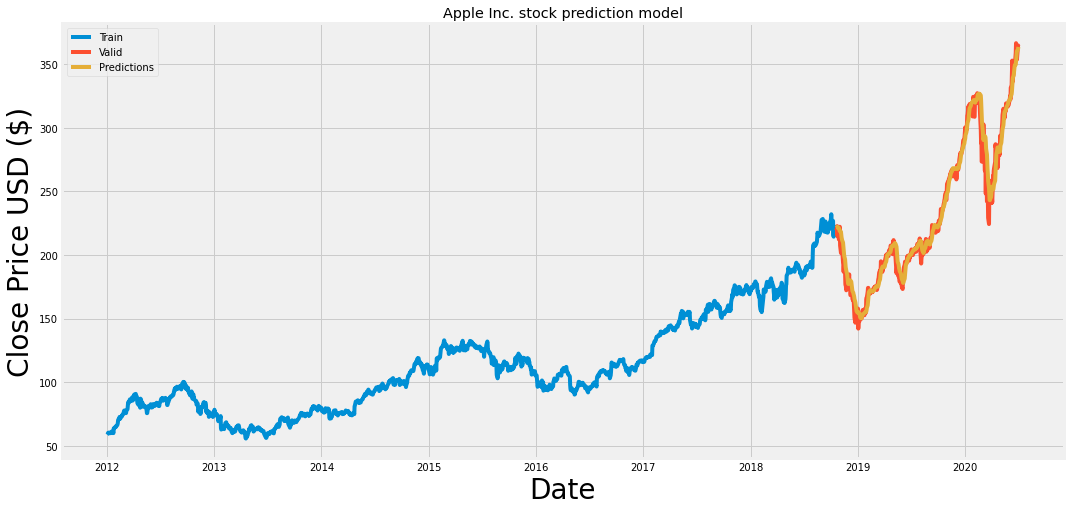

In [68]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid["Predictions"] = predictions

# Visualize the data
plt.figure(figsize = (16, 8))
plt.title("Apple Inc. stock prediction model")
plt.xlabel("Date", fontsize = 28)
plt.ylabel("Close Price USD ($)", fontsize = 28)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Valid", "Predictions"])
plt.show();

In [69]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-10-19,219.309998,221.272690
2018-10-22,220.649994,221.543915
2018-10-23,222.729996,222.093948
2018-10-24,215.089996,222.186310
2018-10-25,219.800003,222.090134
...,...,...
2020-06-25,364.839996,358.429871
2020-06-26,353.630005,360.374756
2020-06-29,361.779999,361.197388


In [70]:
# Get the quote
apple_quote = web.DataReader("AAPL", data_source = "yahoo", start = "2012-01-01", end = "2020-07-25")
# Create a new dataframe
new_df = apple_quote.filter(["Close"])
# Get the last 7 days closing price values and conert the dataframe to an array
last_7_days = new_df[-7:].values
# Scale the data to be values between 0 and 1
last_7_days_scaled = scaler.transform(last_7_days)
# Create an empty list
X_test = []
# Append the past 7 days 
X_test.append(last_7_days_scaled)
# Convert the X_test data set to a numpt array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[384.93335]]
